In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

In [18]:
#loading in data
df = pd.read_csv("Corners_TrainingData.csv")
df.head()


,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,RandNum,Holdout,Unnamed: 11,Unnamed: 12
0,2826,793,02/04/2005,410,908,2.0,0.0,15,1,0.378045,Modelling,NaN,NaN
1,2827,793,02/04/2005,338,597,3.0,2.0,3,6,0.264956,Modelling,NaN,NaN
2,2828,793,02/04/2005,1364,246,2.0,3.0,13,2,0.737558,Modelling,NaN,NaN
3,2829,793,02/04/2005,1088,1397,1.0,0.0,2,5,0.763682,Modelling,NaN,NaN
4,2830,793,02/04/2005,830,1412,2.0,3.0,3,6,0.021615,Modelling,NaN,NaN


In [19]:
#dropping unnamed columns
to_drop = ['Unnamed: 11','Unnamed: 12']
df.drop(to_drop,axis=1, inplace=True)

#modelling_set = df[df['Holdout'] == 'Modelling']
#holdout_set = df[df['Holdout'] == 'Holdout']

In [20]:
#checking drop
df.head()
#modelling_set.head()
#holdout_set.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,RandNum,Holdout
0,2826,793,02/04/2005,410,908,2.0,0.0,15,1,0.378045,Modelling
1,2827,793,02/04/2005,338,597,3.0,2.0,3,6,0.264956,Modelling
2,2828,793,02/04/2005,1364,246,2.0,3.0,13,2,0.737558,Modelling
3,2829,793,02/04/2005,1088,1397,1.0,0.0,2,5,0.763682,Modelling
4,2830,793,02/04/2005,830,1412,2.0,3.0,3,6,0.021615,Modelling


In [95]:
#adding in total corners column
df['Total_Corners'] = df['Home_Corners'] + df['Away_Corners']
df['Total_Goals'] = df['Home_Goals'] + df['Away_Goals']

df.head()

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,RandNum,Holdout,Total_Corners,Total_Goals
0,2826,793,02/04/2005,410,908,2.0,0.0,15,1,0.378045,Modelling,16,2.0
1,2827,793,02/04/2005,338,597,3.0,2.0,3,6,0.264956,Modelling,9,5.0
2,2828,793,02/04/2005,1364,246,2.0,3.0,13,2,0.737558,Modelling,15,5.0
3,2829,793,02/04/2005,1088,1397,1.0,0.0,2,5,0.763682,Modelling,7,1.0
4,2830,793,02/04/2005,830,1412,2.0,3.0,3,6,0.021615,Modelling,9,5.0


In [96]:
#nulls
df.isnull().sum()

MatchId          0
LeagueId         0
Date             0
HomeTeamId       0
AwayTeamId       0
Home_Goals       8
Away_Goals       8
Home_Corners     0
Away_Corners     0
RandNum          0
Holdout          0
Total_Corners    0
Total_Goals      8
dtype: int64

In [97]:
#dropping null rows and reset index
df_clean = df.dropna()
df_clean.reset_index()
df_clean.isnull().sum()

MatchId          0
LeagueId         0
Date             0
HomeTeamId       0
AwayTeamId       0
Home_Goals       0
Away_Goals       0
Home_Corners     0
Away_Corners     0
RandNum          0
Holdout          0
Total_Corners    0
Total_Goals      0
dtype: int64

In [98]:
#comparing total matches
df.count() - df_clean.count()

MatchId          8
LeagueId         8
Date             8
HomeTeamId       8
AwayTeamId       8
Home_Goals       0
Away_Goals       0
Home_Corners     8
Away_Corners     8
RandNum          8
Holdout          8
Total_Corners    8
Total_Goals      0
dtype: int64

In [99]:
#checking how many teams in each league
df.groupby('LeagueId')['HomeTeamId'].nunique()
counts = df.groupby('HomeTeamId')['LeagueId'].nunique()
filtered = counts[counts > 1]
counts_away = df.groupby('AwayTeamId')['LeagueId'].nunique()
f_away = counts_away[counts_away > 1]
filtered.equals(f_away)

True

In [184]:
#feature engineering - lookups for leagues and teams, some teams in more than one league
#Home stats - goals,corners, wins/draws/losses
df_clean['Home_Points'] =np.select([df_clean['Home_Goals'] > df_clean['Away_Goals'],
                                   df_clean['Home_Goals'] == df_clean['Away_Goals'],
                                   df_clean['Home_Goals'] < df_clean['Away_Goals']
                                   ] , [3,1,0])

df_clean['Home_Wins'] = np.select([df_clean['Home_Goals'] > df_clean['Away_Goals'],df_clean['Home_Goals'] <= df_clean['Away_Goals']],[1,0])
df_clean['Home_Draws'] = np.select([df_clean['Home_Goals'] == df_clean['Away_Goals'],df_clean['Home_Goals'] != df_clean['Away_Goals']],[1,0])
df_clean['Home_Losses'] = np.select([df_clean['Home_Goals'] < df_clean['Away_Goals'],df_clean['Home_Goals'] >= df_clean['Away_Goals']],[1,0])


df_clean['Home_Corner_Difference'] = df_clean['Home_Corners'] - df_clean['Away_Corners']
df_clean['Home_Goal_Difference'] = df_clean['Home_Goals'] - df_clean['Away_Goals']


#away stats - goals,corners, wins/draws/losses
df_clean['Away_Points'] =np.select([df_clean['Away_Goals'] > df_clean['Home_Goals'],
                                   df_clean['Away_Goals'] == df_clean['Home_Goals'],
                                   df_clean['Away_Goals'] < df_clean['Home_Goals']
                                   ] , [3,1,0])

df_clean['Away_Wins'] = np.select([df_clean['Away_Goals'] > df_clean['Home_Goals'],df_clean['Away_Goals'] <= df_clean['Home_Goals']],[1,0])
df_clean['Away_Draws'] = np.select([df_clean['Away_Goals'] == df_clean['Home_Goals'],df_clean['Away_Goals'] != df_clean['Home_Goals']],[1,0])
df_clean['Away_Losses'] = np.select([df_clean['Away_Goals'] < df_clean['Home_Goals'],df_clean['Away_Goals'] >= df_clean['Home_Goals']],[1,0])


df_clean['Away_Corner_Difference'] = df_clean['Away_Corners'] - df_clean['Home_Corners']
df_clean['Away_Goal_Difference'] = df_clean['Away_Goals'] - df_clean['Home_Goals']

df_clean_sorted = df_clean.sort_values('Date').reset_index()
df_clean['DateId'] = df_clean_sorted.index + 1



#home team goals and corners features
def home_GC_features(data, period=5):
    data = data.sort_values('Date')
    grouped = data.groupby('HomeTeamId').rolling(window=period, on='Date', closed='left').agg({'Home_Goals':'mean','Away_Goals':'mean','Home_Corners':'mean','Home_Corner_Difference':'mean','Home_Goal_Difference':'mean'}).reset_index()
    grouped.columns=['HomeTeamId', 'Date',
                      'home_avg_goals_scored_5',
                      'home_avg_goals_conceded_5',
                      'home_avg_corners_5',
                      'home_avg_corner_difference_5',
                      'home_avg_goal_difference_5']
    return grouped

#away team goals and corners features, remember to multiply by -1 for GD and CD
def away_GC_features(data, period=5):
    data = data.sort_values('Date')
    grouped = data.groupby('AwayTeamId').rolling(window=period, on='Date', closed='left').agg({'Home_Goals':'mean','Away_Goals':'mean','Away_Corners':'mean','Away_Corner_Difference':'mean','Away_Goal_Difference':'mean'}).reset_index()
    grouped.columns=['AwayTeamId', 'Date',
                      'away_avg_goals_conceded_5',
                      'away_avg_goals_scored_5',
                      'away_avg_corners_5',
                      'away_avg_corner_difference_5',
                      'away_avg_goal_difference_5']
    
    return grouped

#home win/draw/loss features
def home_form_features(data, period=10):
    data = data.sort_values('Date')
    grouped = data.groupby('HomeTeamId').rolling(window=period, on='Date', closed='left').agg({'Home_Points':['sum','std'],'Home_Wins':'sum', 'Home_Draws':'sum','Home_Losses':'sum'}).reset_index()
    grouped.columns = ['HomeTeamId', 'Date',
                      'Home_Points_10',
                      'Home_Points_Std_10',
                      'Home_Wins_10',
                      'Home_Draws_10',
                      'Home_Losses_10']
    grouped['Home_Win_Diff'] = grouped['Home_Wins_10'] - grouped['Home_Draws_10'] - grouped['Home_Losses_10']
    grouped['home_Loss_Diff'] = grouped['Home_Losses_10'] - grouped['Home_Draws_10'] - grouped['Home_Wins_10']
    return grouped

#away form features
def away_form_features(data, period=10):
    data = data.sort_values('Date')
    grouped = data.groupby('AwayTeamId').rolling(window=period, on='Date', closed='left').agg({'Away_Points':['sum','std'],'Away_Wins':'sum', 'Away_Draws':'sum','Away_Losses':'sum'}).reset_index()
    grouped.columns = ['AwayTeamId', 'Date',
                      'Away_Points_10',
                      'Away_Points_Std_10',
                      'Away_Wins_10',
                      'Away_Draws_10',
                      'Away_Losses_10']
    grouped['Away_Win_Diff'] = grouped['Away_Wins_10'] - grouped['Away_Draws_10'] - grouped['Away_Losses_10']
    grouped['Away_Loss_Diff'] = grouped['Away_Losses_10'] - grouped['Away_Draws_10'] - grouped['Away_Wins_10']
    return grouped

#league features
def league_features(data, period=50):
    data = data.sort_values('DateId')
    grouped = data.groupby('LeagueId').rolling(window=period, on='DateId', closed='left').agg({'Total_Corners':'mean', 'Home_Corners':'mean','Away_Corners':'mean','Total_Goals':'mean','Home_Goals':'mean','Away_Goals':'mean','Home_Corner_Difference':'mean','Away_Corner_Difference':'mean','Home_Goal_Difference':'mean','Away_Goal_Difference':'mean'}).reset_index()
    grouped.columns = ['LeagueId', 'DateId',
                      'league_avg_total_corners_50',
                      'league_avg_home_corners_50',
                      'league_avg_away_corners_50',
                      'league_avg_total_goals_50',
                      'league_avg_home_goals_50',
                      'league_avg_away_goals_50',
                      'league_avg_home_corner_diff_50',
                      'league_avg_away_corner_diff_50',
                      'league_avg_home_goal_diff_50',
                      'league_avg_away_goal_diff_50']
    return grouped

#generate features to join
home_GC_features = home_GC_features(df_clean, period=10)
away_GC_features = away_GC_features(df_clean, period=10)
home_form_features = home_form_features(df_clean,period=10)
away_form_features = away_form_features(df_clean,period=10)
league_features = league_features(df_clean,period=50)


#joining
df_merged_h = pd.merge(df_clean, home_GC_features, on=['HomeTeamId','Date'], how='left')
df_merged_ha = pd.merge(df_merged_h,away_GC_features, on=['AwayTeamId','Date'], how='left')
df_merged_ha_hf = pd.merge(df_merged_ha,home_form_features, on=['HomeTeamId','Date'], how='left')
df_merged_ha_hf_af = pd.merge(df_merged_ha_hf,away_form_features, on=['AwayTeamId','Date'], how='left')
df_merged_final = pd.merge(df_merged_ha_hf_af,league_features, on=['LeagueId','DateId'], how='left') 



df_merged_final.head()


#Comparison features - ratios, differences
df_merged_final['home_league_corner_ratio'] = df_merged_final['home_avg_corners_5']/df_merged_final['league_avg_home_corners_50']
df_merged_final['away_league_corner_ratio'] = df_merged_final['away_avg_corners_5']/df_merged_final['league_avg_away_corners_50']
df_merged_final['home_league_goals_ratio'] = df_merged_final['home_avg_goals_scored_5']/df_merged_final['league_avg_home_goals_50']
df_merged_final['away_league_goals_ratio'] = df_merged_final['away_avg_goals_scored_5']/df_merged_final['league_avg_away_goals_50']   

/var/folders/k5/1b6xbllj60n_h0t0rl6r2ztm0000gn/T/ipykernel_70668/2486202400.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Home_Points'] =np.select([df_clean['Home_Goals'] > df_clean['Away_Goals'],
/var/folders/k5/1b6xbllj60n_h0t0rl6r2ztm0000gn/T/ipykernel_70668/2486202400.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Home_Wins'] = np.select([df_clean['Home_Goals'] > df_clean['Away_Goals'],df_clean['Home_Goals'] <= df_clean['Away_Goals']],[1,0])
/var/folders/k5/1b6xbllj60n_h0t

In [185]:
df_merged_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23822 entries, 0 to 23821
Data columns (total 64 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MatchId                         23822 non-null  int64  
 1   LeagueId                        23822 non-null  int64  
 2   Date                            23822 non-null  object 
 3   HomeTeamId                      23822 non-null  int64  
 4   AwayTeamId                      23822 non-null  int64  
 5   Home_Goals                      23822 non-null  float64
 6   Away_Goals                      23822 non-null  float64
 7   Home_Corners                    23822 non-null  int64  
 8   Away_Corners                    23822 non-null  int64  
 9   RandNum                         23822 non-null  float64
 10  Holdout                         23822 non-null  object 
 11  Total_Corners                   23822 non-null  int64  
 12  Total_Goals                     

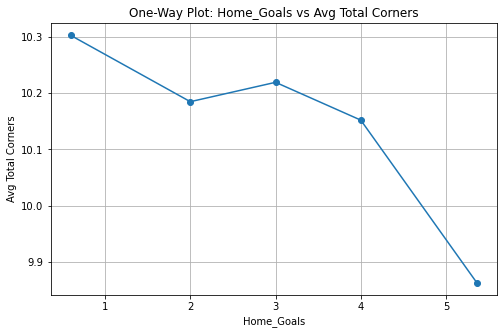

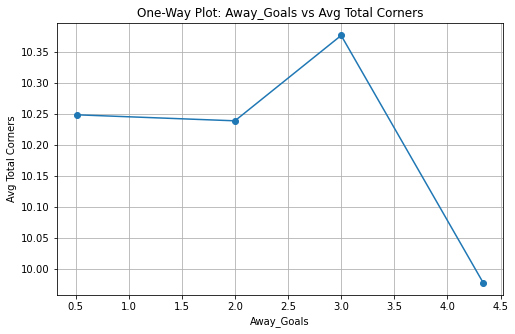

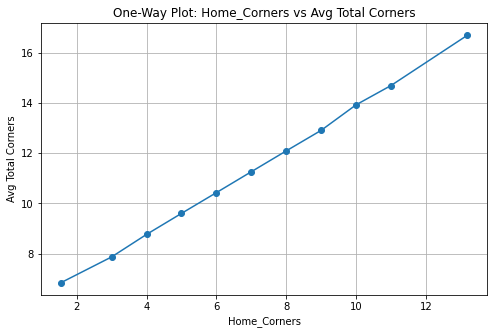

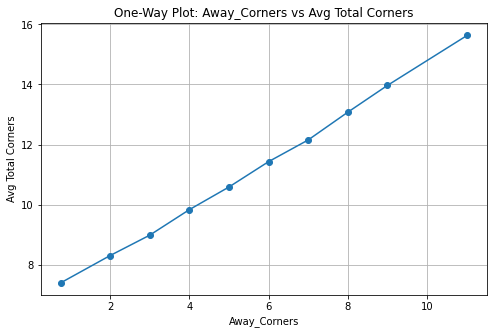

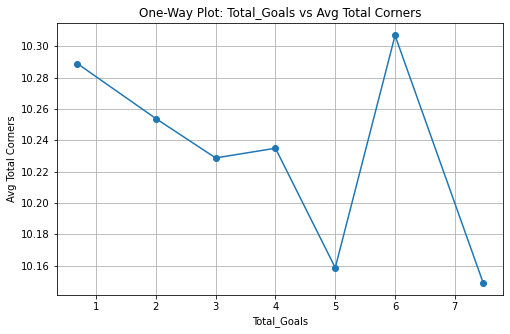

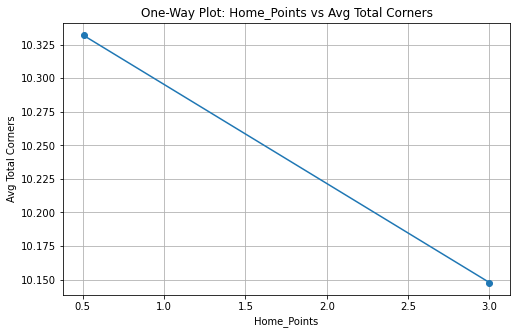

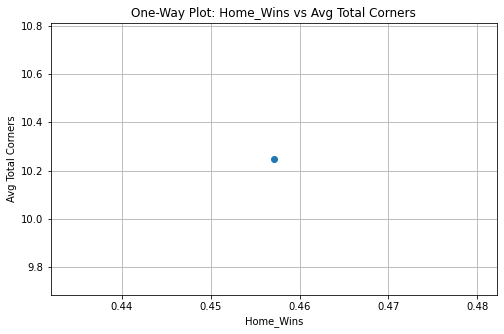

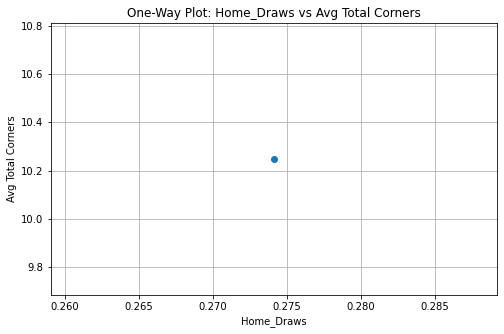

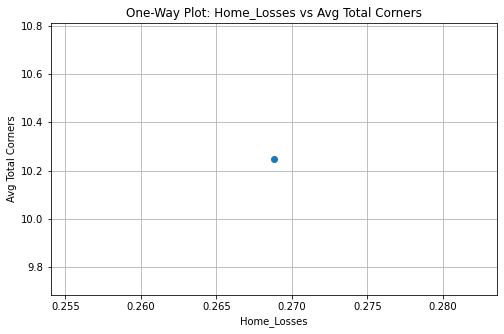

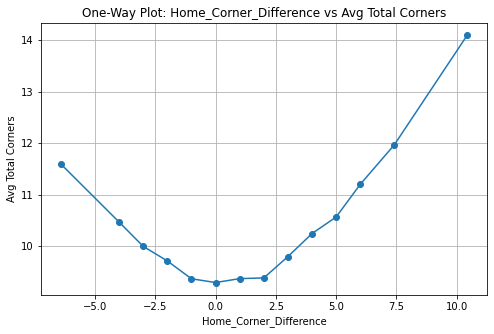

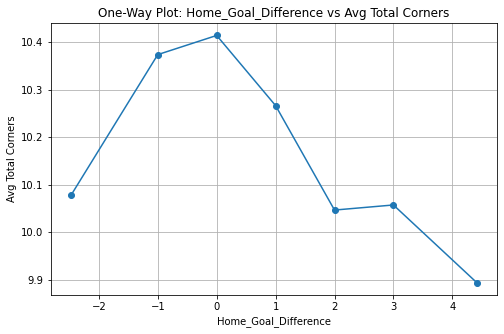

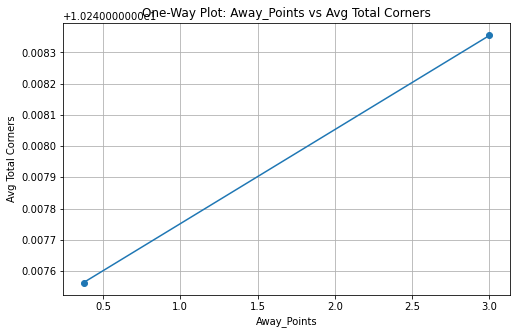

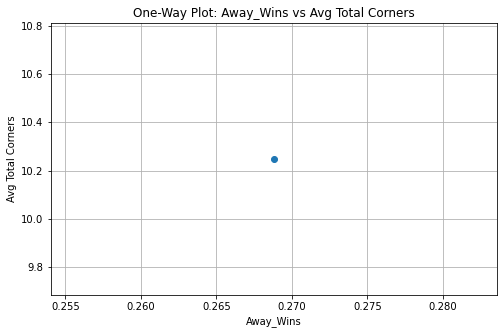

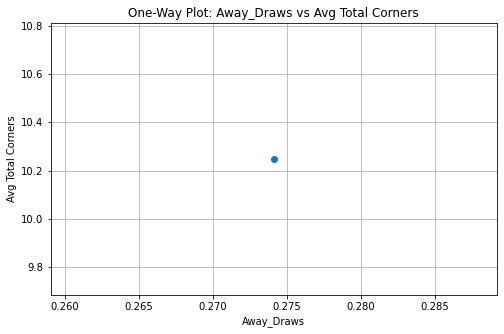

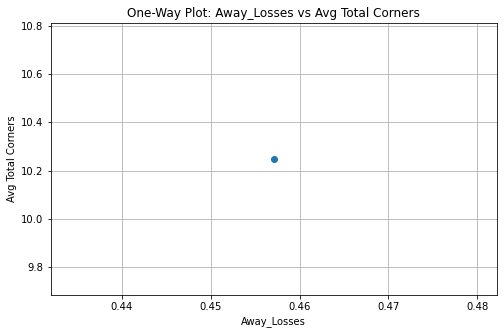

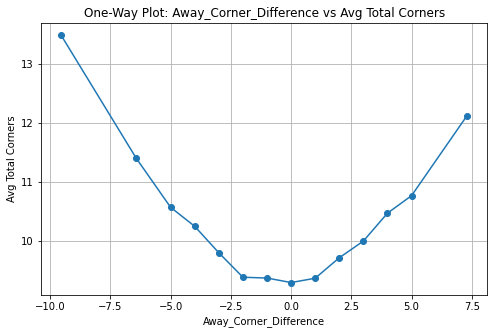

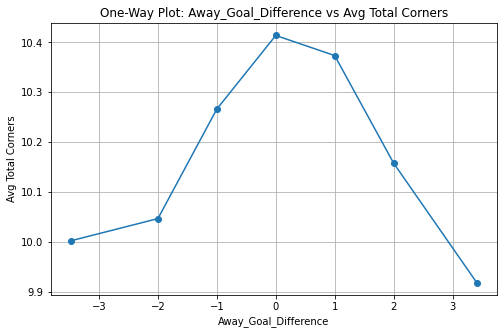

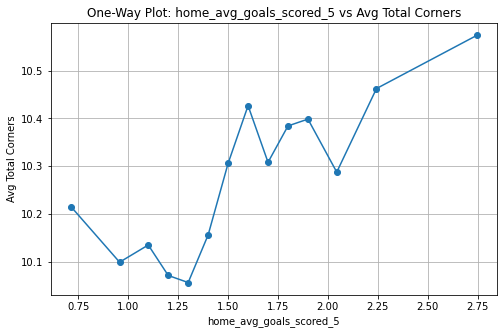

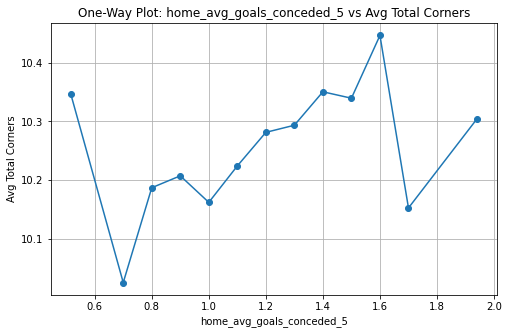

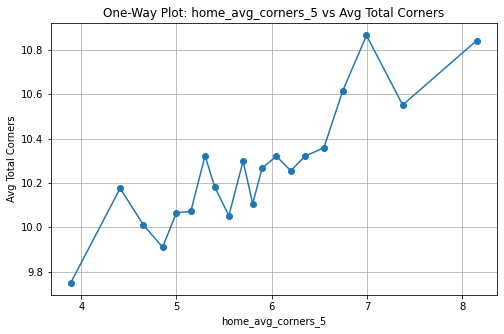

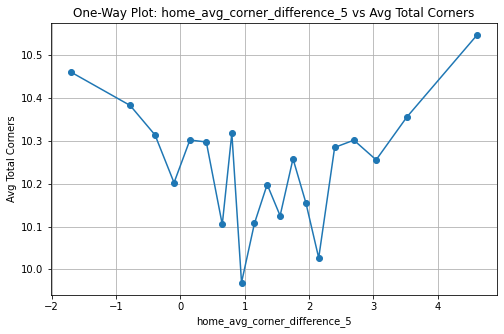

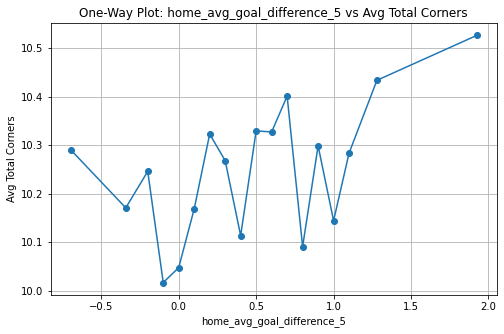

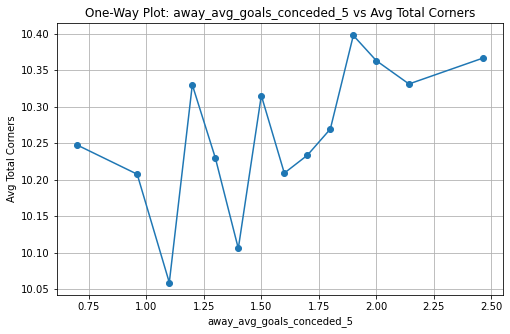

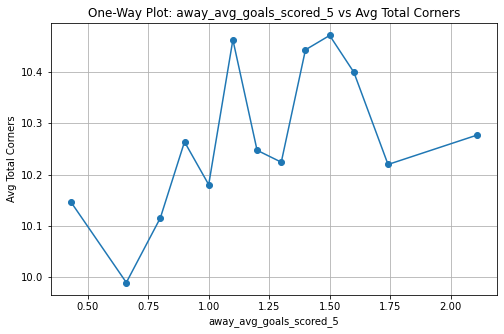

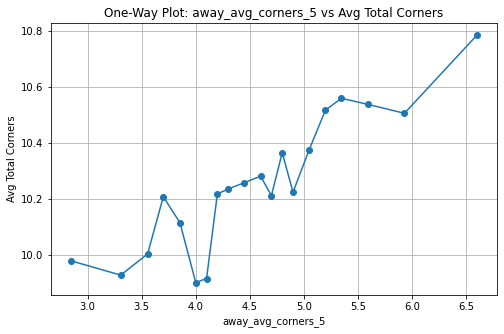

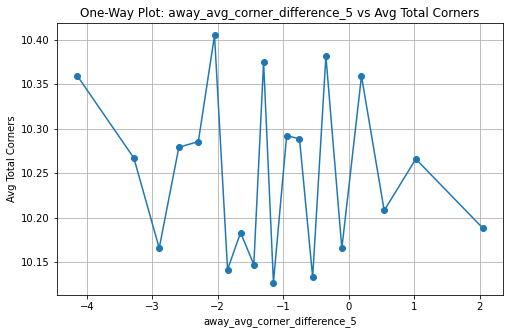

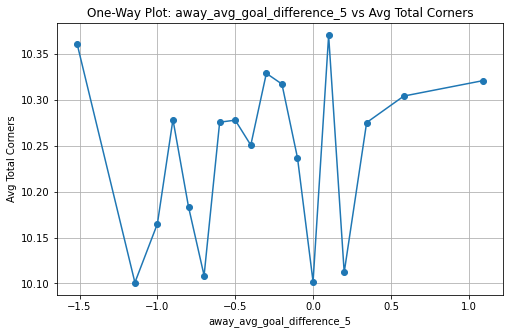

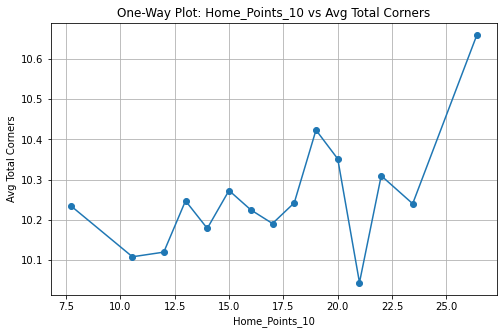

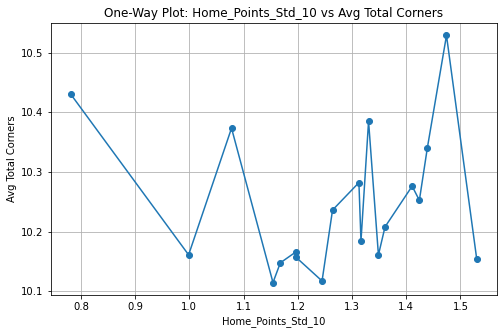

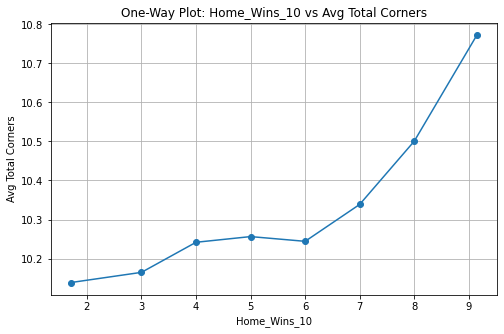

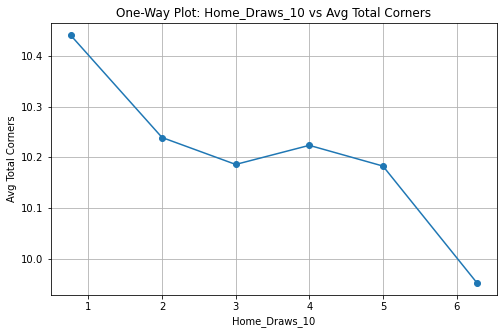

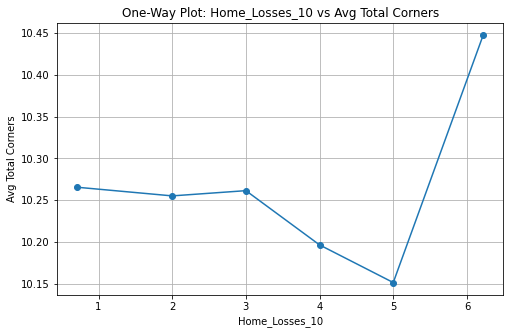

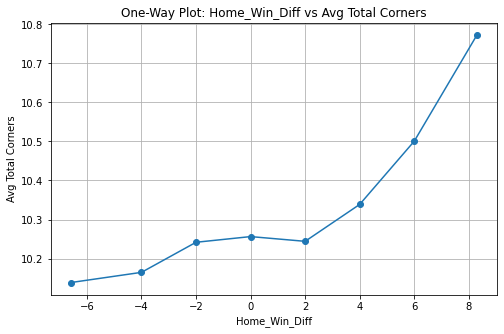

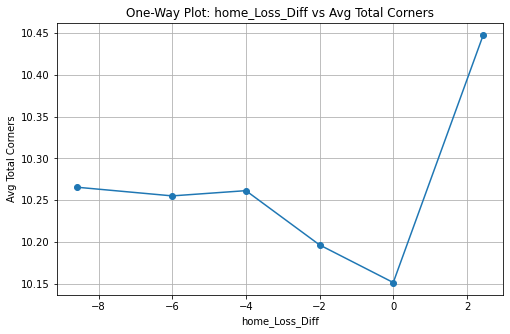

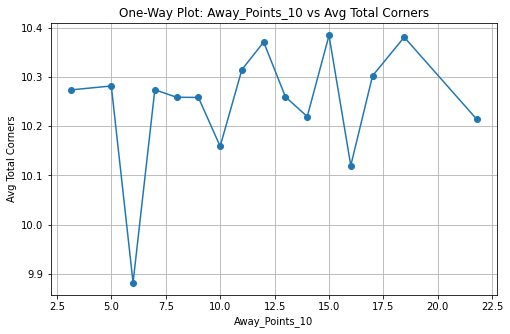

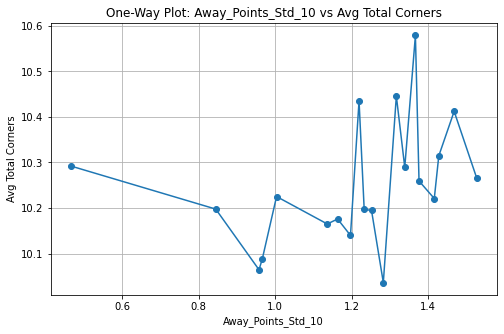

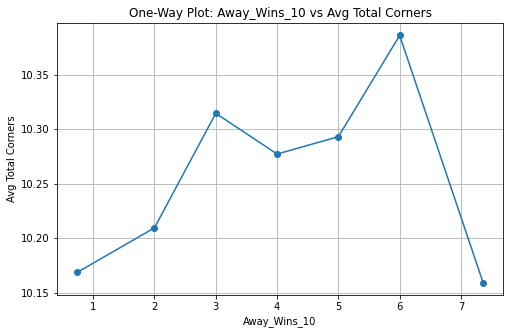

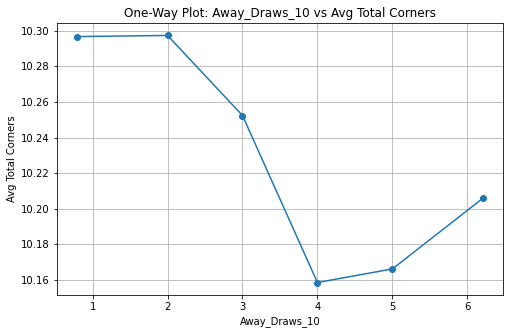

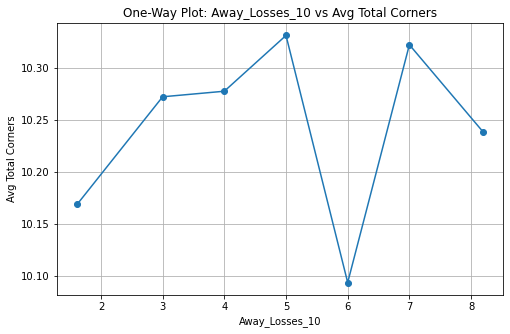

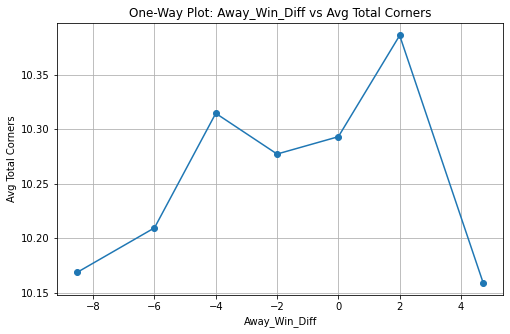

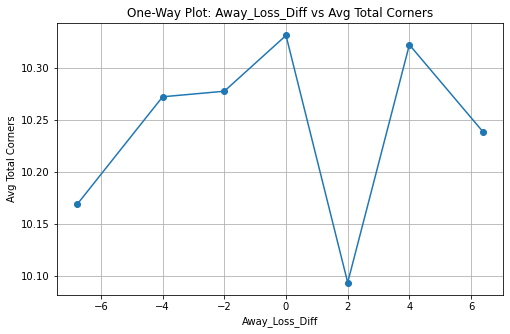

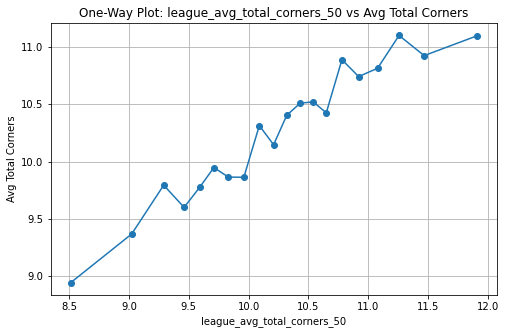

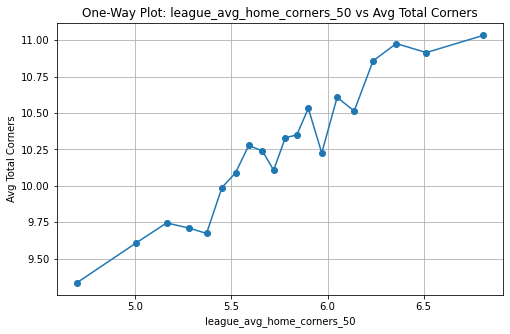

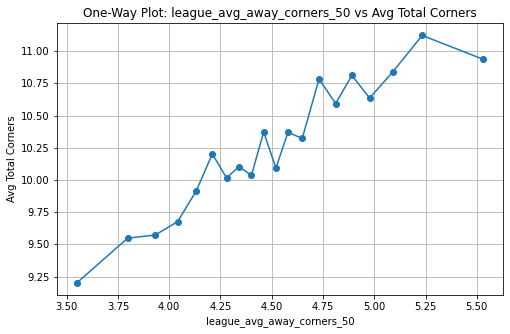

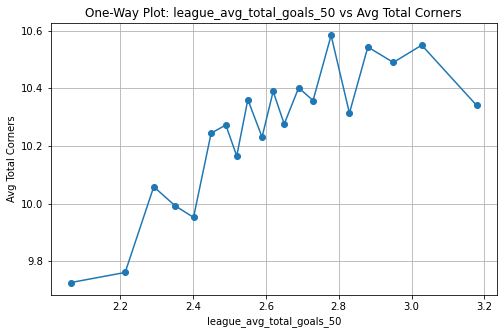

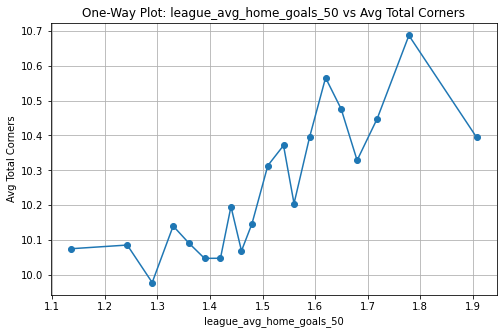

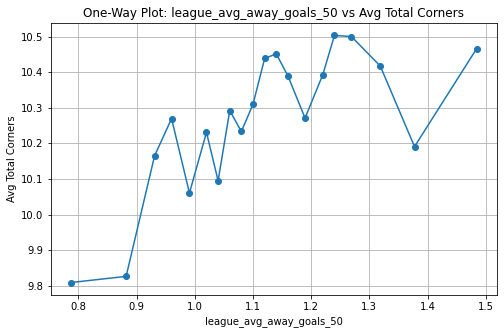

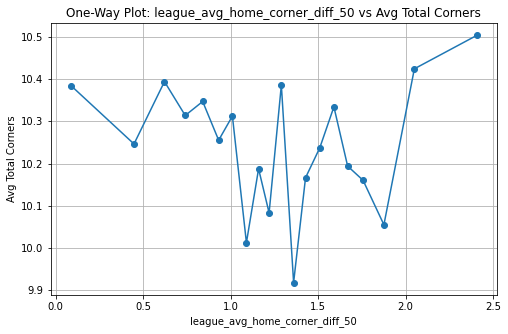

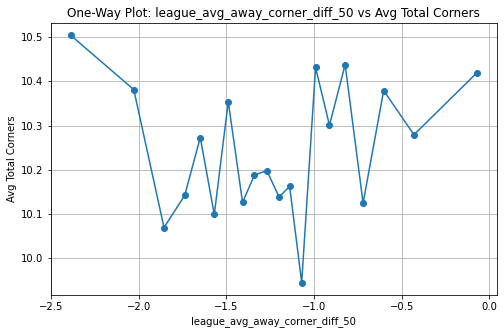

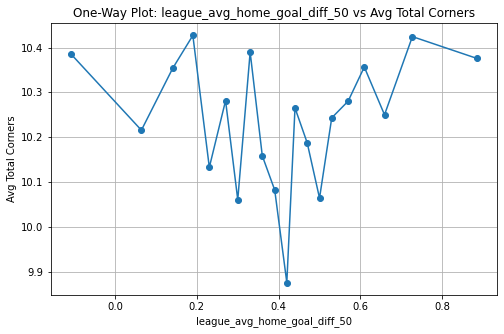

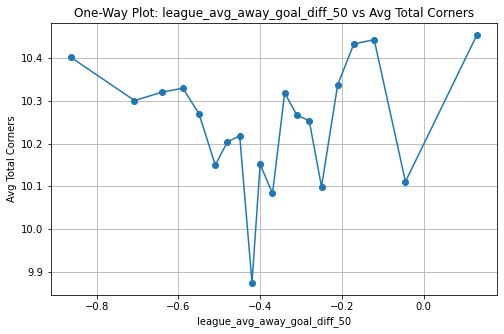

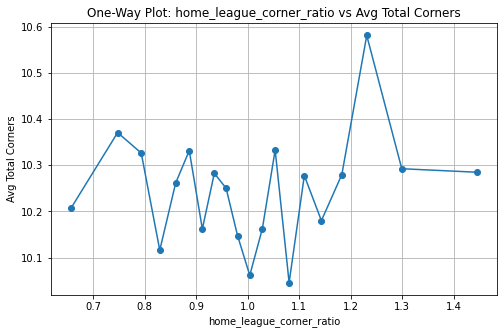

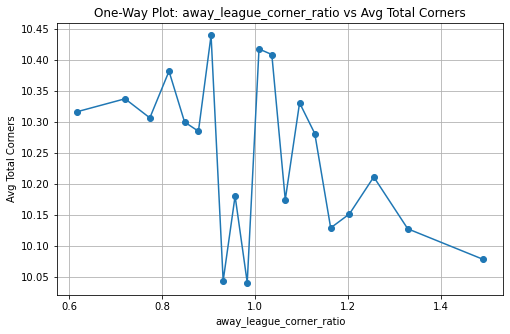

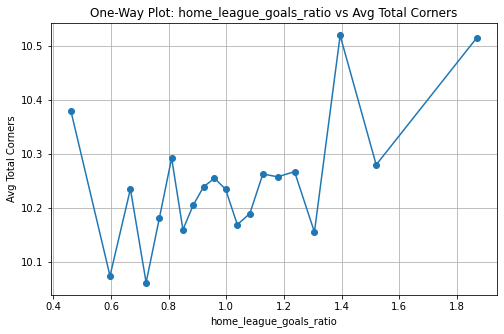

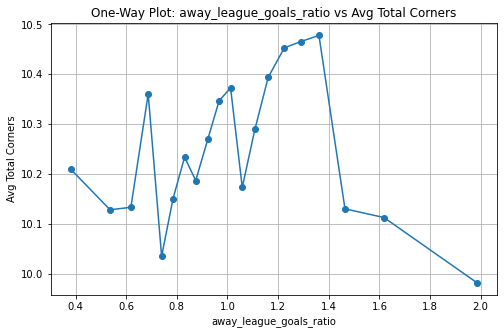

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [209]:
#One ways
def plot_one_ways(df, factor, bins=20):
    #copy banded factors to avoid altering 
    df_plot = df.copy().dropna()
    df_plot['bin'] = pd.qcut(df_plot[factor], q=bins, duplicates='drop')
    grouped = df_plot.groupby('bin').agg({factor: 'mean','Total_Corners': 'mean'}).reset_index()

    x = grouped[factor]
    y = grouped['Total_Corners']

    plt.figure(figsize=(8, 5))
    plt.plot(x, y, marker='o', linestyle='-')
    plt.title(f"One-Way Plot: {factor} vs Avg Total Corners")
    plt.xlabel(factor)
    plt.ylabel("Avg Total Corners")
    plt.grid(True)
    plt.show()


# plotting one ways
columns = df_merged_final.columns
remove = ['MatchId','LeagueId','Date','DateId','HomeTeamId','AwayTeamId','RandNum','Holdout']
factors_to_plot = []

for i in columns:
    if i not in remove:
        factors_to_plot.append(i)



for factor in factors_to_plot:
    if factor != 'Total_Corners':
        plot_one_ways(df_merged_final, factor, bins=20)

<AxesSubplot:title={'center':'Interaction: home × away avg corners'}, xlabel='interaction_bin'>

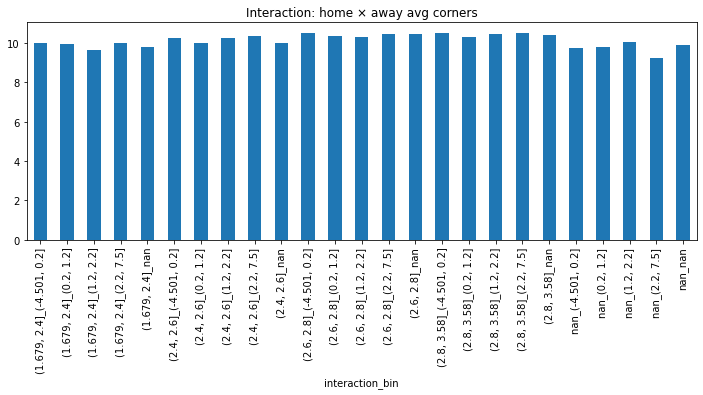

In [174]:

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_merged_final.corr()

,MatchId,LeagueId,HomeTeamId,AwayTeamId,Home_Goals,Away_Goals,Home_Corners,Away_Corners,RandNum,Total_Corners,Total_Goals,Home_Points,Home_Wins,Home_Draws,Home_Losses,Home_Corner_Difference,Home_Goal_Difference,Away_Points,Away_Wins,Away_Draws,Away_Losses,Away_Corner_Difference,Away_Goal_Difference,DateId,home_avg_goals_scored_5,home_avg_goals_conceded_5,home_avg_corners_5,home_avg_corner_difference_5,home_avg_goal_difference_5,away_avg_goals_conceded_5,away_avg_goals_scored_5,away_avg_corners_5,away_avg_corner_difference_5,away_avg_goal_difference_5,Home_Points_10,Home_Points_Std_10,Home_Wins_10,Home_Draws_10,Home_Losses_10,Home_Win_Diff,home_Loss_Diff,Away_Points_10,Away_Points_Std_10,Away_Wins_10,Away_Draws_10,Away_Losses_10,Away_Win_Diff,Away_Loss_Diff,league_avg_total_corners_50,league_avg_home_corners_50,league_avg_away_corners_50,league_avg_total_goals_50,league_avg_home_goals_50,league_avg_away_goals_50,league_avg_home_corner_diff_50,league_avg_away_corner_diff_50,league_avg_home_goal_diff_50,league_avg_away_goal_diff_50
MatchId,1.000000,0.018108,0.119449,0.123750,0.004543,0.029495,0.052257,0.057718,-0.011196,0.084970,0.023002,-0.016078,-0.012026,-0.006400,0.019968,0.000978,-0.015970,0.019193,0.019968,-0.006400,-0.012026,-0.000978,0.015970,0.994010,0.016130,-0.001920,0.027486,0.008588,0.013457,-0.016245,0.008410,0.040519,0.028912,0.016768,0.018795,0.015858,0.020645,-0.015226,-0.009368,0.020645,-0.009368,0.016740,0.008753,0.013006,0.009405,-0.019624,0.013006,-0.019624,0.355767,0.301711,0.293594,0.149240,0.046976,0.190092,0.016509,-0.016509,-0.101335,0.101335
LeagueId,0.018108,1.000000,0.093214,0.091108,-0.025408,0.003025,-0.029936,-0.002204,0.017757,-0.026271,-0.017182,-0.015354,-0.016288,0.009950,0.008273,-0.019412,-0.020973,0.012514,0.008273,0.009950,-0.016288,0.019412,0.020973,0.018168,-0.084647,0.037364,-0.111323,-0.084314,-0.086688,-0.036455,-0.021878,-0.019898,0.028951,0.011442,-0.076091,0.054823,-0.077421,0.039130,0.052105,-0.077421,0.052105,0.002007,0.040923,-0.000970,0.009758,-0.007019,-0.000970,-0.007019,-0.101101,-0.159579,-0.007078,-0.092855,-0.164056,0.032063,-0.141766,0.141766,-0.158198,0.158198
HomeTeamId,0.119449,0.093214,1.000000,0.157642,-0.007618,0.006638,-0.003764,0.004883,0.008807,0.000443,-0.001349,-0.009052,-0.010002,0.007200,0.003981,-0.005593,-0.010052,0.006895,0.003981,0.007200,-0.010002,0.005593,0.010052,0.120475,-0.006745,0.005394,-0.001011,-0.009043,-0.008332,0.004784,-0.037112,-0.028207,-0.010183,-0.027196,-0.011376,-0.003223,-0.016329,0.023217,-0.003149,-0.016329,-0.003149,-0.037521,-0.023812,-0.038499,0.010807,0.026746,-0.038499,0.026746,-0.006834,-0.010884,-0.000378,-0.054104,-0.049183,-0.033064,-0.009763,0.009763,-0.016023,0.016023
AwayTeamId,0.123750,0.091108,0.157642,1.000000,0.009754,-0.012459,-0.011308,0.012201,-0.004878,-0.000462,-0.000901,0.011689,0.011387,-0.004187,-0.008576,-0.015294,0.015469,-0.010754,-0.008576,-0.004187,0.011387,0.015294,-0.015469,0.124789,-0.038824,0.002151,-0.023035,-0.008627,-0.030934,0.029025,-0.012194,0.035377,0.035300,-0.028141,-0.025572,-0.004614,-0.031389,0.032767,0.005155,-0.031389,0.005155,-0.013310,-0.005754,-0.008334,-0.014331,0.019308,-0.008334,0.019308,-0.006398,-0.010631,0.000102,-0.054758,-0.048878,-0.034466,-0.009960,0.009960,-0.014742,0.014742
Home_Goals,0.004543,-0.025408,-0.007618,0.009754,1.000000,-0.010671,-0.030360,0.012594,0.002952,-0.015878,0.748181,0.640450,0.633672,-0.262114,-0.447877,-0.028745,0.754318,-0.577347,-0.447877,-0.262114,0.633672,0.028745,-0.754318,0.006124,0.132456,-0.027954,0.083108,0.088161,0.117678,0.054147,-0.037289,-0.032277,-0.040907,-0.061841,0.097373,-0.066960,0.100255,-0.054388,-0.063962,0.100255,-0.063962,-0.055427,-0.025081,-0.051174,-0.003478,0.050022,-0.051174,0.050022,0.024168,0.016923,0.023639,0.030864,0.028976,0.017836,-0.005510,0.005510,0.010650,-0.010650
Away_Goals,0.029495,0.003025,0.006638,-0.012459,-0.010671,1.000000,0.007952,0.003137,-0.003028,0.008830,0.655472,-0.573938,-0.473841,-0.079527,0.612696

In [212]:
df_merged_final.corr()['Total_Corners']

MatchId                           0.084970
LeagueId                         -0.026271
HomeTeamId                        0.000443
AwayTeamId                       -0.000462
Home_Goals                       -0.015878
Away_Goals                        0.008830
Home_Corners                      0.698984
Away_Corners                      0.583951
RandNum                           0.004342
Total_Corners                     1.000000
Total_Goals                      -0.006132
Home_Points                      -0.018522
Home_Wins                        -0.024601
Home_Draws                        0.028562
Home_Losses                      -0.001149
Home_Corner_Difference            0.127977
Home_Goal_Difference             -0.017663
Away_Points                       0.009102
Away_Wins                        -0.001149
Away_Draws                        0.028562
Away_Losses                      -0.024601
Away_Corner_Difference           -0.127977
Away_Goal_Difference              0.017663
DateId     

In [253]:
#split into modelling and holdout
modelling = df_merged_final[df_merged_final['Holdout'] == 'Modelling']
holdout = df_merged_final[df_merged_final['Holdout'] == 'Holdout']

#feature selection - backward selection
total_features =['home_avg_goals_scored_5', 'home_avg_goals_conceded_5',
       'home_avg_corners_5', 'home_avg_corner_difference_5',
       'home_avg_goal_difference_5', 'away_avg_goals_conceded_5',
       'away_avg_goals_scored_5', 'away_avg_corners_5',
       'away_avg_corner_difference_5', 'away_avg_goal_difference_5',
       'Home_Points_10', 'Home_Points_Std_10', 'Home_Wins_10', 'Home_Draws_10',
       'Home_Losses_10', 'Home_Win_Diff', 'home_Loss_Diff', 'Away_Points_10',
       'Away_Points_Std_10', 'Away_Wins_10', 'Away_Draws_10', 'Away_Losses_10',
       'Away_Win_Diff', 'Away_Loss_Diff', 'league_avg_total_corners_50',
       'league_avg_home_corners_50', 'league_avg_away_corners_50',
       'league_avg_total_goals_50', 'league_avg_home_goals_50',
       'league_avg_away_goals_50', 'league_avg_home_corner_diff_50',
       'league_avg_away_corner_diff_50', 'league_avg_home_goal_diff_50',
       'league_avg_away_goal_diff_50', 'home_league_corner_ratio',
       'away_league_corner_ratio', 'home_league_goals_ratio',
       'away_league_goals_ratio']

#total features filtered - away_avg_goal_difference_5, away_points_10, 
total_features_2 =['home_avg_goals_scored_5', 'home_avg_goals_conceded_5',
       'home_avg_corners_5', 'home_avg_corner_difference_5',
       'home_avg_goal_difference_5', 'away_avg_goals_conceded_5',
       'away_avg_goals_scored_5', 'away_avg_corners_5', 'away_avg_corner_difference_5',
       'Home_Points_10', 'Home_Points_Std_10', 'Home_Wins_10', 'Home_Draws_10',
       'Home_Losses_10', 'Home_Win_Diff', 'home_Loss_Diff',
       'Away_Points_Std_10', 'Away_Wins_10', 'Away_Draws_10', 'Away_Losses_10',
       'Away_Win_Diff', 'Away_Loss_Diff', 'league_avg_total_corners_50',
       'league_avg_total_goals_50', 'league_avg_home_goals_50',
       'league_avg_away_goals_50', 'league_avg_home_corner_diff_50',
        'league_avg_home_goal_diff_50',
        'home_league_corner_ratio',
       'away_league_corner_ratio', 'home_league_goals_ratio']

total_features_3 =['home_avg_goals_scored_5', 'home_avg_goals_conceded_5',
       'home_avg_corners_5', 'home_avg_corner_difference_5',
       'home_avg_goal_difference_5', 'away_avg_goals_conceded_5',
       'away_avg_goals_scored_5', 'away_avg_corners_5', 'away_avg_corner_difference_5',
       'Home_Points_10', 'Home_Points_Std_10', 'Home_Wins_10',
       'Home_Losses_10', 'Home_Win_Diff', 'home_Loss_Diff',
       'Away_Points_Std_10', 'Away_Wins_10', 'Away_Losses_10',
       'Away_Win_Diff', 'Away_Loss_Diff', 'league_avg_total_corners_50',
       'league_avg_total_goals_50', 'league_avg_home_goals_50',
       'league_avg_away_goals_50', 'league_avg_home_corner_diff_50',
        'league_avg_home_goal_diff_50',
        'home_league_corner_ratio',
       'away_league_corner_ratio', 'home_league_goals_ratio']


#home away features
home_features = ['home_avg_goals_scored_5', 'home_avg_goals_conceded_5',
       'home_avg_corners_5', 'home_avg_corner_difference_5',
       'home_avg_goal_difference_5', 'away_avg_goals_conceded_5',
       'away_avg_goals_scored_5', 'away_avg_corners_5',
       'away_avg_corner_difference_5', 'away_avg_goal_difference_5',
       'Home_Points_10', 'Home_Points_Std_10', 'Home_Wins_10', 'Home_Draws_10',
       'Home_Losses_10', 'Home_Win_Diff', 'home_Loss_Diff', 'Away_Points_10',
       'Away_Points_Std_10', 'Away_Wins_10', 'Away_Draws_10', 'Away_Losses_10',
       'Away_Win_Diff', 'Away_Loss_Diff', 'league_avg_total_corners_50',
       'league_avg_home_corners_50', 'league_avg_away_corners_50',
       'league_avg_total_goals_50', 'league_avg_home_goals_50',
       'league_avg_away_goals_50', 'league_avg_home_corner_diff_50',
       'league_avg_away_corner_diff_50', 'league_avg_home_goal_diff_50',
       'league_avg_away_goal_diff_50', 'home_league_corner_ratio',
       'away_league_corner_ratio', 'home_league_goals_ratio',
       'away_league_goals_ratio']

away_features = ['home_avg_goals_scored_5', 'home_avg_goals_conceded_5',
       'home_avg_corners_5', 'home_avg_corner_difference_5',
       'home_avg_goal_difference_5', 'away_avg_goals_conceded_5',
       'away_avg_goals_scored_5', 'away_avg_corners_5',
       'away_avg_corner_difference_5', 'away_avg_goal_difference_5',
       'Home_Points_10', 'Home_Points_Std_10', 'Home_Wins_10', 'Home_Draws_10',
       'Home_Losses_10', 'Home_Win_Diff', 'home_Loss_Diff', 'Away_Points_10',
       'Away_Points_Std_10', 'Away_Wins_10', 'Away_Draws_10', 'Away_Losses_10',
       'Away_Win_Diff', 'Away_Loss_Diff', 'league_avg_total_corners_50',
       'league_avg_home_corners_50', 'league_avg_away_corners_50',
       'league_avg_total_goals_50', 'league_avg_home_goals_50',
       'league_avg_away_goals_50', 'league_avg_home_corner_diff_50',
       'league_avg_away_corner_diff_50', 'league_avg_home_goal_diff_50',
       'league_avg_away_goal_diff_50', 'home_league_corner_ratio',
       'away_league_corner_ratio', 'home_league_goals_ratio',
       'away_league_goals_ratio']

#fit model without interactions
model_total = smf.glm(
    formula='Total_Corners ~ ' + ' + '.join(total_features),
    data=modelling,
    family=sm.families.NegativeBinomial()
).fit()

model_total_filtered = smf.glm(
    formula='Total_Corners ~ ' + ' + '.join(total_features_2),
    data=modelling,
    family=sm.families.NegativeBinomial()
).fit()






#home away models
model_home = smf.glm(
    formula='Home_Corners ~ ' + ' + '.join(home_features),
    data=modelling,
    family=sm.families.NegativeBinomial()
).fit()

model_away = smf.glm(
    formula='Away_Corners ~ ' + ' + '.join(away_features),
    data=modelling,
    family=sm.families.NegativeBinomial()
).fit()

In [351]:
model_3_refitted.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Total_Corners   No. Observations:                15346
Model:                            GLM   Df Residuals:                    15321
Model Family:        NegativeBinomial   Df Model:                           24
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -40275.
Date:                Sat, 14 Jun 2025   Deviance:                       14973.
Time:                        16:45:48   Pearson chi2:                 1.47e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03507
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             0.0087      0.001      6.552      0.000       0.006       0.011
home_avg_goals_scored_5                              -0.0206      0.028     -0.741      0.459      -0.075       0.034
home_avg_goals_conceded_5                            -0.0220      0.021     -1.061      0.289      -0.063       0.019
home_avg_corners_5                                   -0.0009      0.027     -0.033      0.974      -0.055       0.053
home_avg_corner_difference_5                         -0.0226      0.003     -7.280      0.000      -0.029      -0.017
home_avg_goal_difference_5                            0.0014      0.016      0.083      0.934      -0.030       0.033
away_avg_goals_conceded_5                            -0.0043      0.011     -0.405      0.686      -0.025       0.017
away_avg_goals_scored_5                               0.0014      0.025      0.058      0.954      -0.047       0.049
away_avg_corners_5                                    0.0982      0.026      3.730      0.000       0.047       0.150
away_avg_corner_difference_5                         -0.0136      0.003     -4.833      0.000      -0.019      -0.008
Home_Points_10                                        0.0610      0.009      6.556      0.000       0.043       0.079
Home_Points_Std_10                                   -0.0069      0.019     -0.366      0.714      -0.044       0.030
Home_Wins_10                                          0.0108      0.002      6.540      0.000       0.008       0.014
Home_Losses_10                                        0.0476      0.007      6.589      0.000       0.033       0.062
Home_Win_Diff                                        -0.0653      0.010     -6.469      0.000      -0.085      -0.045
home_Loss_Diff                                        0.0082      0.002      4.956      0.000       0.005       0.011
Away_Points_Std_10                                    0.0110      0.017      0.639      0.523      -0.023       0.045
Away_Wins_10                                          0.0337      0.005      6.219      0.000       0.023       0.044
Away_Losses_10                                        0.0354      0.005      6.598      0.000       0.025       0.046
Away_Win_Diff                                        -0.0194      0.003     -6.504      0.000      -0.025      -0.014
Away_Loss_Diff                                       -0.0162      0.003     -5.665      0.000      -0.022      -0.011
league_avg_total_corners_50                           0.0264      0.019      1.392      0.164      -0.011       0.063
league_avg_total_goals_50                             0.0212      0.015      1.392      0.164      -0.009       0.051
league_avg_home

In [343]:
#AICc = AIC + 2k(k+1)/(n-k-1)
k = len(total_features_2)
n = model_3_refitted.nobs
aic = model_3_refitted.aic

aicc = aic + 2*k*(k+1)/(n-k-1)

print(aic)
print(aicc)

80600.60919453634
80600.73874919221


In [341]:
#disperion parameter
y = df_merged_final["Total_Corners"]
mean_y = y.mean()
var_y = y.var()

alpha_empirical = (var_y - mean_y) / (mean_y ** 2)
print(alpha_empirical)

0.016172979440241195


<AxesSubplot:title={'center':'One-Way Plot: f1 vs f2'}, xlabel='interaction_bin'>

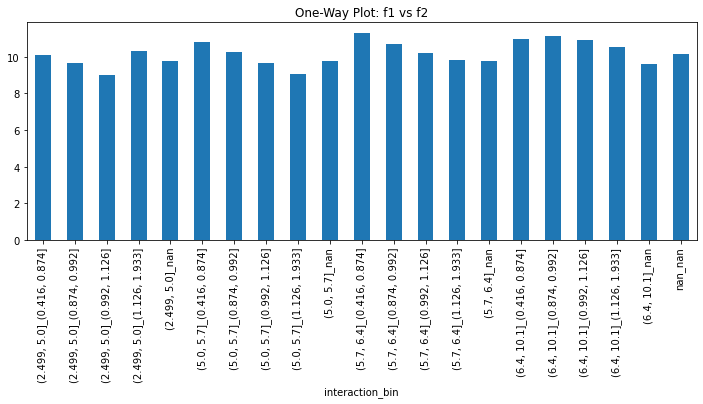

In [267]:
#fit models without interactions and filtered using one-way, AICc and P values
#interactions
df_merged_final['interaction_bin'] = pd.qcut(df_merged_final['home_avg_corners_5'], 4).astype(str) + "_" + pd.qcut(df_merged_final['home_league_corner_ratio'], 4).astype(str)
df_merged_final.groupby('interaction_bin')['Total_Corners'].mean().plot(kind='bar', figsize=(12,4), title=f"One-Way Plot: f1 vs f2")

In [342]:
#model with interactions
model_total_f_int = smf.glm(
    formula='Total_Corners ~ ' + ' + '.join(total_features_3) + '+  away_avg_goals_scored_5:home_avg_goals_conceded_5 + home_league_corner_ratio:away_league_corner_ratio + home_avg_corners_5:home_league_corner_ratio',
    data=modelling,
    family=sm.families.NegativeBinomial()
).fit()

model_3_refitted = smf.glm(
    formula='Total_Corners ~ ' + ' + '.join(total_features_3) + '+  away_avg_goals_scored_5:home_avg_goals_conceded_5 + home_league_corner_ratio:away_league_corner_ratio + home_avg_corners_5:home_league_corner_ratio',
    data=modelling,
    family=sm.families.NegativeBinomial(alpha=0.016172979440241195)
).fit()

In [345]:
#Output predictions for modelling and holdout set
modelling_predictions_1 = model_total.predict(modelling)
modelling_predictions_2 = model_total_filtered.predict(modelling)
modelling_predictions_3 = model_total_f_int.predict(modelling)


holdout_predictions_1=model_total.predict(holdout)
holdout_predictions_2=model_total_filtered.predict(holdout)
holdout_predictions_3=model_total_f_int.predict(holdout)
holdout_predictions_4=model_3_refitted.predict(holdout)

#AvE
modelling_predictions_1.info()


to_plot = pd.DataFrame()
to_plot['Total_Corners'] = holdout['Total_Corners']
to_plot['Predictions'] = holdout_predictions_4

to_plot.info()

plot_data = to_plot.dropna()

<class 'pandas.core.series.Series'>
Int64Index: 19025 entries, 0 to 23821
Series name: None
Non-Null Count  Dtype  
--------------  -----  
15346 non-null  float64
dtypes: float64(1)
memory usage: 297.3 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4797 entries, 9 to 23818
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Total_Corners  4797 non-null   int64  
 1   Predictions    3873 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 112.4 KB


In [346]:
plot_data.to_csv('AvE_holdout_refitted.csv', index=False)

In [323]:
#Join latest rolling stats to test data

#home goals and corners
last_date = home_GC_features['Date'].max()
home_latest_features = (
    home_GC_features[home_GC_features['Date'] <= last_date]
    .sort_values('Date')
    .groupby('HomeTeamId')
    .tail(1)
    .drop(columns='Date')
)


home_latest_features.head()
home_latest_features.info()

#away goals and corners
last_date = away_GC_features['Date'].max()
away_latest_features = (
    away_GC_features[home_GC_features['Date'] <= last_date]
    .sort_values('Date')
    .groupby('AwayTeamId')
    .tail(1)
    .drop(columns='Date')
)

away_latest_features.head()
away_latest_features.info()


#home form
last_date = home_form_features['Date'].max()
home_latest_form = (
    home_form_features[home_form_features['Date'] <= last_date]
    .sort_values('Date')
    .groupby('HomeTeamId')
    .tail(1)
    .drop(columns='Date')
)


home_latest_form.head()
home_latest_form.info()

#away form
last_date = away_form_features['Date'].max()
away_latest_form = (
    away_form_features[away_form_features['Date'] <= last_date]
    .sort_values('Date')
    .groupby('AwayTeamId')
    .tail(1)
    .drop(columns='Date')
)

away_latest_form.info()


#league features
last_date = league_features['DateId'].max()
league_features_latest = (
    league_features[league_features['DateId'] <= last_date]
    .sort_values('DateId')
    .groupby('LeagueId')
    .tail(1)
    .drop(columns='DateId')
)

league_features_latest.info()
print(league_features_latest)




#Output predictions
#Implied probabilities

<class 'pandas.core.frame.DataFrame'>
Int64Index: 332 entries, 23207 to 16965
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   HomeTeamId                    332 non-null    int64  
 1   home_avg_goals_scored_5       322 non-null    float64
 2   home_avg_goals_conceded_5     322 non-null    float64
 3   home_avg_corners_5            322 non-null    float64
 4   home_avg_corner_difference_5  322 non-null    float64
 5   home_avg_goal_difference_5    322 non-null    float64
dtypes: float64(5), int64(1)
memory usage: 18.2 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 333 entries, 16537 to 10291
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   AwayTeamId                    333 non-null    int64  
 1   away_avg_goals_conceded_5     323 non-null    float64
 2   away_avg_goals_s

In [329]:
#imputing
home_GC_latest = home_latest_features.fillna(home_latest_features.mean())
home_GC_latest.head()

away_GC_latest = away_latest_features.fillna(away_latest_features.mean())
away_GC_latest.head()

home_form_latest = home_latest_form.fillna(home_latest_form.mean())
home_form_latest.head()

away_form_latest = away_latest_form.fillna(away_latest_form.mean())
away_form_latest.head()

,AwayTeamId,Away_Points_10,Away_Points_Std_10,Away_Wins_10,Away_Draws_10,Away_Losses_10,Away_Win_Diff,Away_Loss_Diff
16537,1152,10.272446,1.162430,2.513932,2.73065,4.755418,-4.972136,-0.489164
12825,978,10.272446,1.162430,2.513932,2.73065,4.755418,-4.972136,-0.489164
748,243,10.272446,1.162430,2.513932,2.73065,4.755418,-4.972136,-0.489164
11493,906,10.272446,1.162430,2.513932,2.73065,4.755418,-4.972136,-0.489164
19243,1345,4.000000,0.966092,1.000000,1.00000,8.000000,-8.000000,6.000000


In [331]:
#join to test set
df_test_set = pd.read_csv("Corners_test_set.csv")

to_drop = ['Unnamed: 5','Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10','Unnamed: 11','Unnamed: 12','Unnamed: 13']
df_test_set.drop(to_drop,axis=1, inplace=True)

test_merged_h = pd.merge(df_test_set,home_GC_latest, on=['HomeTeamId'], how='left')
test_merged_a = pd.merge(test_merged_h,away_GC_latest, on=['AwayTeamId'], how='left')
test_merged_hf = pd.merge(test_merged_a,home_form_latest, on=['HomeTeamId'], how='left')
test_merged_af = pd.merge(test_merged_hf,away_form_latest, on=['AwayTeamId'], how='left')
test_merged_l = pd.merge(test_merged_af,league_features_latest, on=['LeagueId'], how='left')

test_merged_l.info()

#ratio features - recompute once joined
test_merged_l['home_league_corner_ratio'] = test_merged_l['home_avg_corners_5']/test_merged_l['league_avg_home_corners_50']
test_merged_l['away_league_corner_ratio'] = test_merged_l['away_avg_corners_5']/test_merged_l['league_avg_away_corners_50']
test_merged_l['home_league_goals_ratio'] = test_merged_l['home_avg_goals_scored_5']/test_merged_l['league_avg_home_goals_50']
test_merged_l['away_league_goals_ratio'] = test_merged_l['away_avg_goals_scored_5']/test_merged_l['league_avg_away_goals_50']   

test_merged_l.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 0 to 340
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MatchId                         341 non-null    int64  
 1   LeagueId                        341 non-null    int64  
 2   Date                            341 non-null    object 
 3   HomeTeamId                      341 non-null    int64  
 4   AwayTeamId                      341 non-null    int64  
 5   home_avg_goals_scored_5         341 non-null    float64
 6   home_avg_goals_conceded_5       341 non-null    float64
 7   home_avg_corners_5              341 non-null    float64
 8   home_avg_corner_difference_5    341 non-null    float64
 9   home_avg_goal_difference_5      341 non-null    float64
 10  away_avg_goals_conceded_5       341 non-null    float64
 11  away_avg_goals_scored_5         341 non-null    float64
 12  away_avg_corners_5              341 

,MatchId,LeagueId,Date,HomeTeamId,AwayTeamId,home_avg_goals_scored_5,home_avg_goals_conceded_5,home_avg_corners_5,home_avg_corner_difference_5,home_avg_goal_difference_5,away_avg_goals_conceded_5,away_avg_goals_scored_5,away_avg_corners_5,away_avg_corner_difference_5,away_avg_goal_difference_5,Home_Points_10,Home_Points_Std_10,Home_Wins_10,Home_Draws_10,Home_Losses_10,Home_Win_Diff,home_Loss_Diff,Away_Points_10,Away_Points_Std_10,Away_Wins_10,Away_Draws_10,Away_Losses_10,Away_Win_Diff,Away_Loss_Diff,league_avg_total_corners_50,league_avg_home_corners_50,league_avg_away_corners_50,league_avg_total_goals_50,league_avg_home_goals_50,league_avg_away_goals_50,league_avg_home_corner_diff_50,league_avg_away_corner_diff_50,league_avg_home_goal_diff_50,league_avg_away_goal_diff_50,home_league_corner_ratio,away_league_corner_ratio,home_league_goals_ratio,away_league_goals_ratio
0,1,741,01/04/2011,342,694,2.7,1.2,4.8,0.6,1.5,0.6,2.8,5.2,1.0,2.2,20.0,1.054093e+00,5.0,5.0,0.0,0.0,-10.0,28.0,0.632456,9.0,1.0,0.0,8.0,-10.0,11.02,6.60,4.42,2.94,1.76,1.18,2.18,-2.18,0.58,-0.58,0.727273,1.176471,1.534091,2.372881
1,2,741,01/04/2011,1424,270,2.0,0.9,6.5,1.5,1.1,0.9,1.2,4.8,0.1,0.3,19.0,1.449138e+00,6.0,1.0,3.0,2.0,-4.0,19.0,1.449138,6.0,1.0,3.0,2.0,-4.0,11.02,6.60,4.42,2.94,1.76,1.18,2.18,-2.18,0.58,-0.58,0.984848,1.085973,1.136364,1.016949
2,3,729,01/04/2011,691,1137,1.4,1.1,5.8,0.5,0.3,1.4,0.9,5.4,-0.7,-0.5,16.0,1.264911e+00,4.0,4.0,2.0,-2.0,-6.0,10.0,0.816497,1.0,7.0,2.0,-8.0,-6.0,10.56,5.92,4.64,2.80,1.46,1.34,1.28,-1.28,0.12,-0.12,0.979730,1.163793,0.958904,0.671642
3,4,729,01/04/2011,787,808,1.2,1.2,5.9,1.4,0.0,1.6,2.2,4.8,-0.6,0.6,15.0,1.354006e+00,4.0,3.0,3.0,-2.0,-4.0,19.0,1.449138,6.0,1.0,3.0,2.0,-4.0,10.56,5.92,4.64,2.80,1.46,1.34,1.28,-1.28,0.12,-0.12,0.996622,1.034483,0.821918,1.641791
4,5,741,01/04/2011,784,1117,3.6,0.6,7.5,3.1,3.0,1.7,1.3,4.3,-1.6,-0.4,30.0,2.329755e-08,10.0,0.0,0.0,10.0,-10.0,7.0,0.948683,1.0,4.0,5.0,-8.0,0.0,11.02,6.60,4.42,2.94,1.76,1.18,2.18,-2.18,0.58,-0.58,1.136364,0.972851,2.045455,1.101695


In [347]:
#model 3 predictions
test_predictions = model_3_refitted.predict(test_merged_l)
test_predictions.head()

0    10.404799
1    10.729663
2    10.634659
3    10.420601
4    11.461665
dtype: float64

In [348]:
#outputting test predictions
test_predictions.to_csv('Test_Predictions_refitted.csv', index=False)

In [350]:
total_features_3

['home_avg_goals_scored_5',
 'home_avg_goals_conceded_5',
 'home_avg_corners_5',
 'home_avg_corner_difference_5',
 'home_avg_goal_difference_5',
 'away_avg_goals_conceded_5',
 'away_avg_goals_scored_5',
 'away_avg_corners_5',
 'away_avg_corner_difference_5',
 'Home_Points_10',
 'Home_Points_Std_10',
 'Home_Wins_10',
 'Home_Losses_10',
 'Home_Win_Diff',
 'home_Loss_Diff',
 'Away_Points_Std_10',
 'Away_Wins_10',
 'Away_Losses_10',
 'Away_Win_Diff',
 'Away_Loss_Diff',
 'league_avg_total_corners_50',
 'league_avg_total_goals_50',
 'league_avg_home_goals_50',
 'league_avg_away_goals_50',
 'league_avg_home_corner_diff_50',
 'league_avg_home_goal_diff_50',
 'home_league_corner_ratio',
 'away_league_corner_ratio',
 'home_league_goals_ratio']